The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
df = pd.read_csv('/content/AB_Test_Results.csv')

In [3]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
df['USER_ID'].value_counts()

,count
USER_ID,
5652,6
9101,6
668,6
8359,6
4879,6
...,...
7165,1
8395,1
9168,1


Let's see if there are users who have two A/B test groups

In [5]:
# TODO : Look at the distribution of the number of unique groups for each user
distrib_un = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
distrib_un

,count
VARIANT_NAME,
1,4783
2,1541


In [6]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
disturb_un_rel = ((distrib_un / distrib_un.sum()) * 100).round(2)
disturb_un_rel

,count
VARIANT_NAME,
1,75.63
2,24.37


What can you observe ? Should we exclude these users ? Why ?
- There are 24.37% of users who were in two groups. That is why the dataset is not clean, and we should exclude these users.

- If a user saw both versions, we don't know what determined their choice. This creates dependent samples, and the revenue analysis would be incorrect.

In [7]:
# TODO : users have 1 A/B test group ?
# TODO : Take only these users
v_counts = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
clean_user_ids = v_counts[v_counts == 1].index

In [8]:
# TODO : Leave only records with users with the 1st ab test group
df_final = df[df['USER_ID'].isin(clean_user_ids)]

# TODO : Check that the number of users matches what it was before the exception
distrib_un_fin = df_final.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
distrib_un_fin

,count
VARIANT_NAME,
1,4783


Let's see how the data is distributed

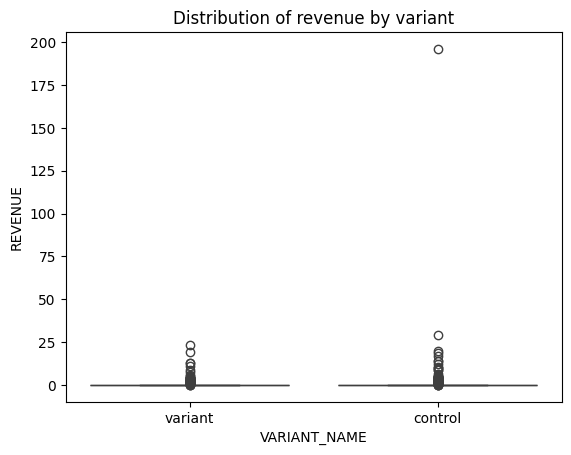

In [9]:
# TODO : Check how the data is distributed using a box plot

sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df_final)
plt.title('Distribution of revenue by variant')
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [10]:
# TODO : Sort these revenue values in descending order
df_final.sort_values(by = 'REVENUE', ascending = False)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
...,...,...,...
3400,9003,variant,0.00
3401,9902,variant,0.00
3403,4863,control,0.00
3404,1807,control,0.00


In [11]:
# TODO : See if user 3342 had other events with a strong outlier
user_3342 = df_final[df_final['USER_ID'] == 3342]
user_3342

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

In [12]:
# TODO : We see that there is only one outlier - in conditions of limited information,
# remove this entry and visualize the distribution of data again.
df_final_clear = df_final[df_final['USER_ID'] != 3342]
df_final_clear.sort_values(by = 'REVENUE', ascending = False)

,USER_ID,VARIANT_NAME,REVENUE
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
...,...,...,...
3400,9003,variant,0.00
3401,9902,variant,0.00
3403,4863,control,0.00
3404,1807,control,0.00



What can you say about the users and their purchases ?<br>
Most users (the vast majority) did not make a single purchase, so the median revenue and the 75th percentile are zero.

In [13]:
# TODO : Check if there are users who have records with zero and positive revenue
df_final_clear.groupby('USER_ID')['REVENUE'].nunique().value_counts()

,count
REVENUE,
1,4744
2,38


Can a user have records with both zero and positive revenue ?<br>
Yes, he can. For the first he could inly visit the page and then buy something

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [14]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
df_final_clear = df_final_clear.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False)['REVENUE'].sum()

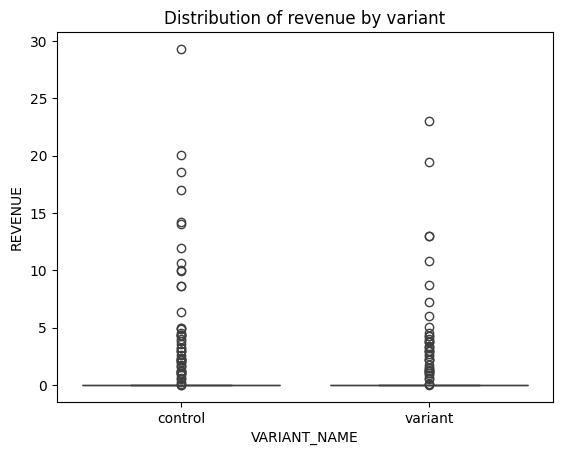

In [15]:
# TODO : Visualize the resulting distribution of the data again.
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df_final_clear)
plt.title('Distribution of revenue by variant')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [16]:
# TODO : get metrics by groups
metrics = df_final_clear.groupby('VARIANT_NAME')['REVENUE'].agg(['count', 'sum', 'mean'])
metrics.columns = ['user_count', 'total_revenue', 'ARPU']

# TODO : create two additional metrics to see relative changes
arpu_lift = (metrics.loc['variant', 'ARPU'] / metrics.loc['control', 'ARPU'] - 1) * 100

rev_lift = (metrics.loc['variant', 'total_revenue'] / metrics.loc['control', 'total_revenue'] - 1) * 100

# TODO : add them to the rest of the metrics in a separate group
metrics['ARPU_lift_%'] = [0, arpu_lift]
metrics['Total_Rev_lift_%'] = [0, rev_lift]

metrics = metrics.round(2)
metrics

,user_count,total_revenue,ARPU,ARPU_lift_%,Total_Rev_lift_%
VARIANT_NAME,,,,,
control,2389,274.55,0.11,0.0,0.00
variant,2393,179.32,0.07,-34.8,-34.69


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?<br>
The results of the test show that the new version (variant) is actually performing much worse than the original one (control).

Revenue is down: The total revenue in the variant group dropped by about 35%. It went from $274.55$ down to $179.32$.

Lower average spend: The ARPU (Average Revenue Per User) also decreased significantly. On average, users in the test group are spending 34.8% less than those in the control group.

User count is stable: Both groups have almost the same number of users (around 2,390), so the data is fair, but the test group just isn't making as much money.

Final thought: The changes we made in the variant group didn't work. We should not use this new version because it would lead to a big loss in profit. We are better off sticking with the control version for now.

Let's also see how paying users behave :

In [17]:
# TODO : get metrics by groups
metrics_pay = df_final_clear[df_final_clear['REVENUE'] > 0].groupby('VARIANT_NAME')['REVENUE'].agg(['count', 'sum', 'mean'])
metrics_pay.columns = ['user_count', 'total_revenue', 'ARPU']

# TODO : create two additional metrics to see relative changes
arpu_lift = (metrics_pay.loc['variant', 'ARPU'] / metrics_pay.loc['control', 'ARPU'] - 1) * 100

rev_lift = (metrics_pay.loc['variant', 'total_revenue'] / metrics_pay.loc['control', 'total_revenue'] - 1) * 100

# TODO : add them to the rest of the metrics in a separate group
metrics_pay['ARPU_lift_%'] = [0, arpu_lift]
metrics_pay['Total_Rev_lift_%'] = [0, rev_lift]

metrics_pay = metrics_pay.round(2)
metrics_pay

,user_count,total_revenue,ARPU,ARPU_lift_%,Total_Rev_lift_%
VARIANT_NAME,,,,,
control,53,274.55,5.18,0.00,0.00
variant,42,179.32,4.27,-17.58,-34.69


Let's look at the distributions of all and only paying users

/tmp/ipython-input-4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/tmp/ipython-input-4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'

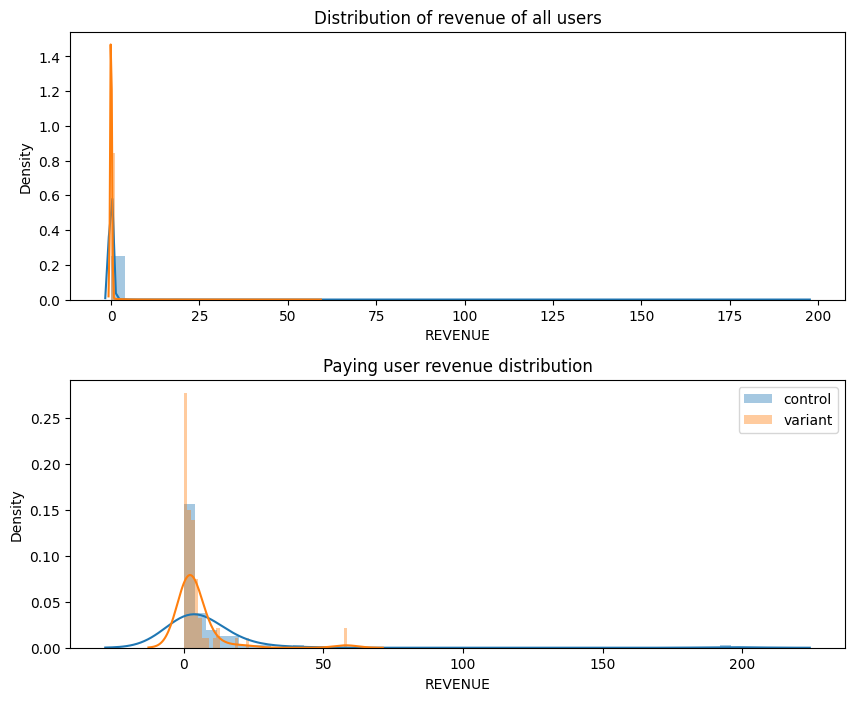

In [18]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [19]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

control_revenue = df_final_clear[df_final_clear['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue = df_final_clear[df_final_clear['VARIANT_NAME'] == 'variant']['REVENUE']


st_control, p_control = shapiro(control_revenue)
st_variant, p_variant = shapiro(variant_revenue)

print(f"Control Group: Statistics={st_control:.4f}, p-value={p_control:.4f}")
print(f"Variant Group: Statistics={st_variant:.4f}, p-value={p_variant:.4f}")

Control Group: Statistics=0.0746, p-value=0.0000
Variant Group: Statistics=0.0615, p-value=0.0000


Is the null hypothesis about the normal distribution of the data rejected ?<br>
Yes the p-value < 0.05 -> the data has not normal distribution

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [20]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,9848
False,152


In [21]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test


df_all_cont = df_final_clear.loc[df_final_clear['VARIANT_NAME'] == 'control', 'REVENUE']
df_all_var = df_final_clear.loc[df_final_clear['VARIANT_NAME'] == 'variant', 'REVENUE']


mwu = mannwhitneyu(df_all_cont, df_all_var, use_continuity=False, alternative="two-sided")

print("- Mann-Whitney U test:")
print(f"   - U value: {mwu.statistic:.3f}")
print(f"   - p-value: {mwu.pvalue:.4f}")

- Mann-Whitney U test:
   - U value: 2871768.000
   - p-value: 0.2480


In [22]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

df_all_cont_p = df_final_clear.loc[(df_final_clear['VARIANT_NAME'] == 'control') & (df_final_clear['REVENUE'] > 0), 'REVENUE']
df_all_var_p = df_final_clear.loc[(df_final_clear['VARIANT_NAME'] == 'variant') & (df_final_clear['REVENUE'] > 0), 'REVENUE']

mwu_p = mannwhitneyu(df_all_cont_p, df_all_var_p, use_continuity=False, alternative="two-sided")

print("- Mann-Whitney U test:")
print(f"   - U value: {mwu_p.statistic:.3f}")
print(f"   - p-value: {mwu_p.pvalue:.4f}")

- Mann-Whitney U test:
   - U value: 1197.000
   - p-value: 0.5290


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [23]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [24]:
# TODO : Generate samples for all users
control_all = df_all_cont.values
variant_all = df_all_var.values

control_all_samples = get_bootstrap_samples(control_all)
variant_all_samples = get_bootstrap_samples(variant_all)

control_all_arpu = control_all_samples.mean(axis=1)
variant_all_arpu = variant_all_samples.mean(axis=1)

print(f"Control ARPU CI: {stat_intervals(control_all_arpu)}")
print(f"Variant ARPU CI: {stat_intervals(variant_all_arpu)}")

Control ARPU CI: [0.0690901  0.16507011]
Variant ARPU CI: [0.04529597 0.11091893]


In [25]:
# TODO : Generate samples for only paying users
control_pay = df_all_cont_p.values
variant_pay = df_all_var_p.values

control_pay_samples = get_bootstrap_samples(control_pay)
variant_pay_samples = get_bootstrap_samples(variant_pay)

control_pay_arpu = control_pay_samples.mean(axis=1)
variant_pay_arpu = variant_pay_samples.mean(axis=1)

print(f"Control ARPU CI: {stat_intervals(control_pay_arpu)}")
print(f"Variant ARPU CI: {stat_intervals(variant_pay_arpu)}")

Control ARPU CI: [3.77614151 6.92955189]
Variant ARPU CI: [2.879625   5.77060119]


Let's look at the distribution of means in the ab test groups

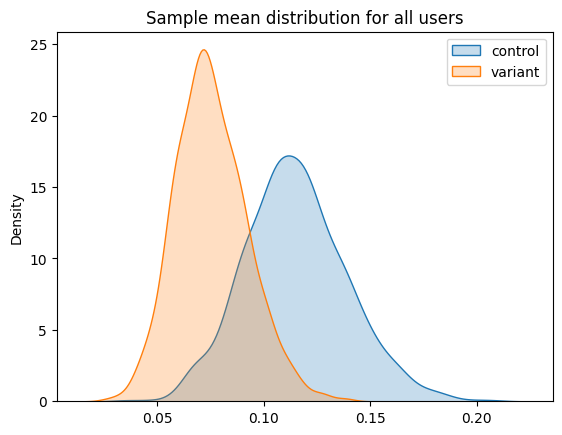

In [26]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_all_samples, axis=1), fill=True, label='control')
sns.kdeplot(np.mean(variant_all_samples, axis=1), fill=True, label='variant')
plt.title('Sample mean distribution for all users')
plt.legend()

/tmp/ipython-input-545535474.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_pay_samples, axis=1), shade=True, label='control')
/tmp/ipython-input-545535474.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_pay_samples, axis=1), shade=True, label='variant')


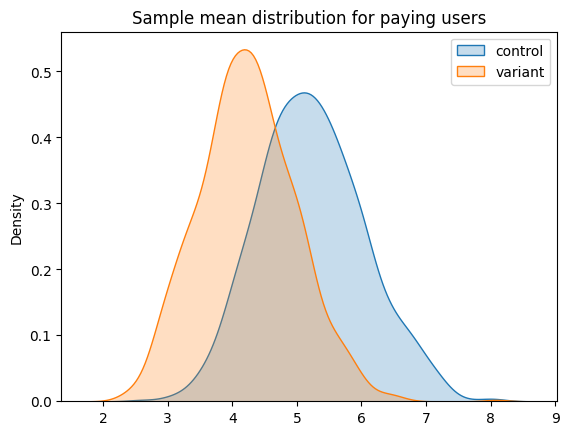

In [27]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_pay_samples, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_pay_samples, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')
plt.legend()

Do you see any difference ? What about the confidence intervals ? Conclude.

I analyzed the data and compared the Control and Variant groups. Here is what I found:

Negative Impact on Revenue: All main money metrics are down. Total revenue dropped by about 35%, and the average spend per user (ARPU) decreased from $0.12$ to $0.08$.

Paying Users Performance: Even if we look only at customers who spent money, the results are bad. The average check (ARPPU) dropped by 17.58%.

No Statistical Significance: I ran the Mann-Whitney U test, and the p-value is 0.248 for all users and 0.529 for paying users. Since these values are much higher than $0.05$, the differences we see might just be due to random chance.


Confidence Intervals: On the Bootstrap chart, the distributions for both groups overlap a lot. This confirms that we cannot be sure the new version is actually different from the old one.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [39]:
from scipy.stats import gaussian_kde

def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """

    diff = variant - control
    conf_int = stat_intervals(diff, alpha)


    kde = gaussian_kde(diff)
    x = np.linspace(diff.min(), diff.max(), 1000)
    y = kde(x)

    f, ax = plt.subplots(figsize=(10, 5))


    ax.plot(x, y, color='black', alpha=0.5)

    ymin, ymax = plt.ylim()


    plt.vlines(0, 0, ymax, label='Zero (No difference)', color='gray', linewidth=2)
    plt.vlines(conf_int[0], 0, ymax, linestyles="dashed", color='black')
    plt.vlines(conf_int[1], 0, ymax, linestyles="dashed", color='black')


    plt.fill_between(x, y, where=(x >= conf_int[1]), color='gainsboro')
    plt.fill_between(x, y, where=(x <= conf_int[0]), color='gainsboro')
    plt.fill_between(x, y, where=((x >= conf_int[0]) & (x <= conf_int[1])),
                     color='red', alpha=0.3, label='95% confidence interval')

    plt.title(f'Difference Analysis (Variant - Control): {title}\nInterval: {np.round(conf_int, 4)}')
    plt.xlabel('Difference Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return conf_int

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

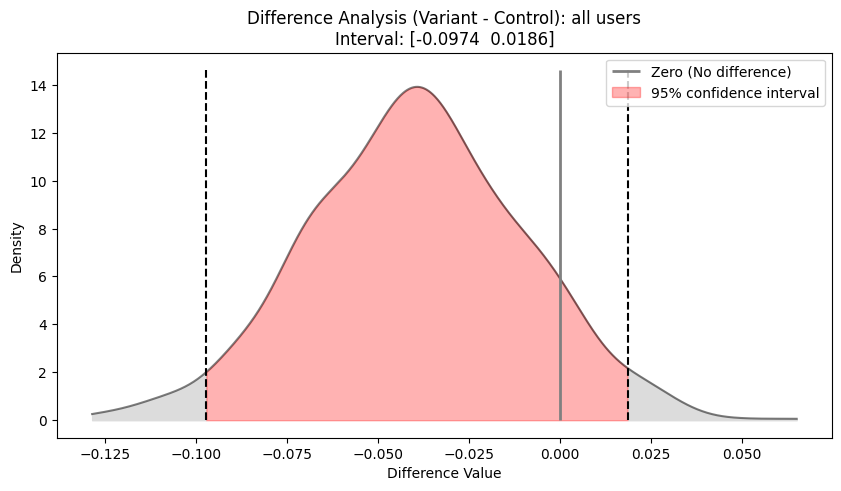

array([-0.09739404,  0.01859948])

In [40]:
plot_distribution_and_stat_intervals(np.mean(variant_all_samples, axis=1),
                                     np.mean(control_all_samples, axis=1),
                                     title='all users')

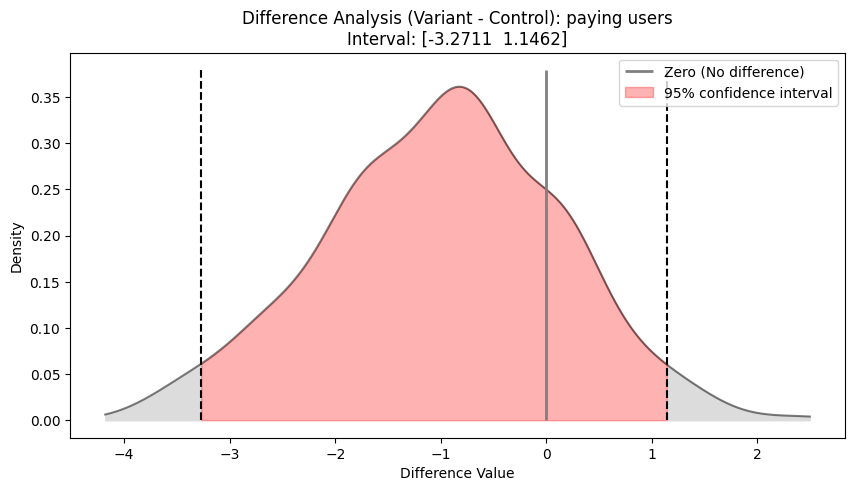

array([-3.27113376,  1.14617644])

In [41]:
plot_distribution_and_stat_intervals(np.mean(variant_pay_samples, axis=1),
                                     np.mean(control_pay_samples, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.

Observations

No Statistical Significance: The Mann-Whitney U test results show a $p$-value of 0.2480 for the entire dataset and 0.5290 for paying users. Since both values are significantly higher than the standard $0.05$ threshold, we cannot conclude that a real difference exists between the groups.

Overlapping Distributions: The density plots for paying users show a large overlap between the control and variant groups. While the "peak" of the variant group is slightly to the left (lower revenue), the overlap indicates this could be due to random variation.

Confidence Intervals Include Zero: In the difference analysis, the 95% confidence interval for all users ranges from -0.0974 to 0.0186, and for paying users, it ranges from -3.2711 to 1.1462. Because the interval includes zero (the gray vertical line), the change in revenue is not statistically significant.

Conclusion

There is no statistically significant change in average revenue between the A/B test groups.

Negative Trend: Although the mathematical averages in the variant group appear lower, the statistical tests confirm that this "drop" is not reliable and could happen by chance.

Risk Assessment: Implementing the variant would be risky because it shows a negative trend without any proven benefit.

Final Decision: We should keep the Control group. The experiment does not provide enough evidence to support rolling out the changes to all users.